In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
user_events = pd.read_csv('Encrypted Datasets/filtered_user_events.csv')
user_segments = pd.read_csv('Encrypted Datasets/user_segment_slice.csv')
body_users = pd.read_csv('Encrypted Datasets/body_users.csv')

In [5]:
user_events.head()

,id,user_id,name,date_mod
0,778739492,5970559,Trade result successful,2025-01-01 00:00:08.018
1,778739498,8835246,User logged in,2025-01-01 00:00:09.433
2,778739499,8835246,Authentication completed,2025-01-01 00:00:09.440
3,778739501,8835246,User logged in,2025-01-01 00:00:10.109
4,778739502,8835246,Authentication completed,2025-01-01 00:00:10.114


In [7]:
# Преобразуем столбцы с датами в datetime
user_events['date_mod'] = pd.to_datetime(user_events['date_mod'])


In [11]:
# Анализ общей активности
user_activity = user_events.groupby('user_id').agg(
    total_events=('id', 'count'),
    unique_events=('name', 'nunique'),
    first_event_date=('date_mod', 'min'),
    last_event_date=('date_mod', 'max'),
    active_days=('date_mod', lambda x: x.dt.date.nunique())
).reset_index()

# Расчет дополнительных метрик
user_activity['activity_duration_days'] = (user_activity['last_event_date'] - user_activity['first_event_date']).dt.days
user_activity['events_per_day'] = user_activity['total_events'] / user_activity['activity_duration_days'].replace(0, 1)
user_activity['avg_daily_events'] = user_activity['total_events'] / user_activity['active_days'].replace(0, 1)

# Заменяем бесконечные значения на 0
user_activity = user_activity.replace([np.inf, -np.inf], 0)

In [12]:
user_activity.head()

,user_id,total_events,unique_events,first_event_date,last_event_date,active_days,activity_duration_days,events_per_day,avg_daily_events
0,151692,123,8,2025-01-15 16:20:32.654,2025-06-28 14:43:16.679,88,163,0.754601,1.397727
1,314546,5,4,2025-01-18 05:25:00.496,2025-05-19 15:05:26.468,3,121,0.041322,1.666667
2,399125,1,1,2025-01-18 04:16:48.089,2025-01-18 04:16:48.089,1,0,1.000000,1.000000
3,413506,1,1,2025-01-18 04:46:54.763,2025-01-18 04:46:54.763,1,0,1.000000,1.000000
4,775310,78,7,2025-01-18 08:26:07.463,2025-06-27 16:05:55.341,29,160,0.487500,2.689655


In [13]:
user_activity.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 419215 entries, 0 to 419214
Data columns (total 9 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   user_id                 419215 non-null  int64         
 1   total_events            419215 non-null  int64         
 2   unique_events           419215 non-null  int64         
 3   first_event_date        419215 non-null  datetime64[ns]
 4   last_event_date         419215 non-null  datetime64[ns]
 5   active_days             419215 non-null  int64         
 6   activity_duration_days  419215 non-null  int64         
 7   events_per_day          419215 non-null  float64       
 8   avg_daily_events        419215 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(5)
memory usage: 28.8 MB


In [33]:
# Создаем маппинг из user_segment
user_id_mapping = user_segments[['user_id', 'original_client_user_id']].drop_duplicates()

# Проверяем маппинг
print(f"Уникальных user_id в маппинге: {user_id_mapping['user_id'].nunique()}")
print(f"Уникальных original_user_id в маппинге: {user_id_mapping['original_client_user_id'].nunique()}")

# Проверяем, есть ли user_id с несколькими original_user_id
mapping_check = user_id_mapping.groupby('user_id').size()
if any(mapping_check > 1):
    print("Внимание: есть user_id с несколькими original_client_user_id")
    print(mapping_check[mapping_check > 1])
    # Берем первый original_user_id для каждого user_id
    user_id_mapping = user_id_mapping.groupby('user_id').first().reset_index()
else:
    print("Маппинг user_id -> original_client_user_id корректен")

Уникальных user_id в маппинге: 516128
Уникальных original_user_id в маппинге: 261541
Внимание: есть user_id с несколькими original_client_user_id
user_id
1337780     2
1337883     2
1408744     2
1409212     2
1447920     2
           ..
11897930    2
11898272    2
12005804    2
12608990    2
12615398    2
Length: 152, dtype: int64


In [35]:
# Объединяем user_events с маппингом
user_events_with_original = user_events.merge(
    user_id_mapping,
    on='user_id',
    how='left'
)

# Проверяем результат
print(f"Размер исходного user_events: {len(user_events)}")
print(f"Размер после объединения: {len(user_events_with_original)}")
print(f"Пропущенных original_client_user_id: {user_events_with_original['original_client_user_id'].isna().sum()}")
print(f"Процент пропусков: {(user_events_with_original['original_client_user_id'].isna().sum() / len(user_events_with_original) * 100):.2f}%")

# Посмотрим на первые несколько строк
print("\nПервые 5 строк user_events_with_original:")
print(user_events_with_original[['user_id', 'original_client_user_id', 'name', 'date_mod']].head())

Размер исходного user_events: 27742819
Размер после объединения: 27742819
Пропущенных original_client_user_id: 0
Процент пропусков: 0.00%

Первые 5 строк user_events_with_original:
   user_id  original_client_user_id                      name  \
0  5970559               2814994585   Trade result successful   
1  8835246               9290835338            User logged in   
2  8835246               9290835338  Authentication completed   
3  8835246               9290835338            User logged in   
4  8835246               9290835338  Authentication completed   

                 date_mod  
0 2025-01-01 00:00:08.018  
1 2025-01-01 00:00:09.433  
2 2025-01-01 00:00:09.440  
3 2025-01-01 00:00:10.109  
4 2025-01-01 00:00:10.114  


In [37]:
# Группируем события по original_user_id
user_activity_agg = user_events_with_original.groupby('original_client_user_id').agg(
    total_events=('id', 'count'),
    unique_events=('name', 'nunique'),
    total_accounts=('user_id', 'nunique'),  # количество счетов у пользователя
    unique_categories=('name', 'nunique'),
    first_event_date=('date_mod', 'min'),
    last_event_date=('date_mod', 'max'),
    active_days=('date_mod', lambda x: x.dt.date.nunique())
).reset_index()

# Расчет метрик
user_activity_agg['activity_duration_days'] = (user_activity_agg['last_event_date'] - user_activity_agg['first_event_date']).dt.days
user_activity_agg['events_per_day'] = user_activity_agg['total_events'] / user_activity_agg['activity_duration_days'].replace(0, 1)
user_activity_agg['avg_daily_events'] = user_activity_agg['total_events'] / user_activity_agg['active_days'].replace(0, 1)
user_activity_agg = user_activity_agg.replace([np.inf, -np.inf], 0)

print(f"Создано {len(user_activity_agg)} записей на уровне пользователей")

Создано 210103 записей на уровне пользователей


In [38]:
# Сегментация по активности на уровне пользователей
def create_user_activity_segments(row):
    total_events = row['total_events']
    if total_events >= 200:
        return 'Супер-активные'
    elif total_events >= 100:
        return 'Очень активные'
    elif total_events >= 50:
        return 'Активные'
    elif total_events >= 20:
        return 'Умеренные'
    elif total_events >= 5:
        return 'Пассивные'
    else:
        return 'Неактивные'

user_activity_agg['activity_segment'] = user_activity_agg.apply(create_user_activity_segments, axis=1)

# Посмотрим распределение
segment_distribution = user_activity_agg['activity_segment'].value_counts()
print("Распределение по сегментам активности:")
print(segment_distribution)

Распределение по сегментам активности:
activity_segment
Неактивные        59609
Умеренные         44296
Супер-активные    34655
Очень активные    27122
Пассивные         25888
Активные          18533
Name: count, dtype: int64


In [53]:
# Объединяем с body_users
user_profiles_complete = user_activity_agg.merge(
    body_users[['original_client_user_id', 'sex_type', 'age_segment', 'Канал привлечения']],
    on='original_client_user_id',
    how='left'
)

# Добавляем сегменты активов - берем МАКСИМАЛЬНЫЙ сегмент для каждого пользователя
# (так как 12 = много активов = лучше)
user_segment_agg = user_segments.groupby('original_client_user_id').agg({
    'user_segment_in_reception_id': 'max'  # берем наивысший сегмент активов
}).reset_index()

user_segment_agg = user_segment_agg.rename(columns={'user_segment_in_reception_id': 'asset_segment'})

# Объединяем с нашими данными
user_profiles_complete = user_activity_agg.merge(
    user_segment_agg,
    on='original_client_user_id',
    how='left'
)

print(f"Итоговый размер датафрейма: {user_profiles_complete.shape}")

Итоговый размер датафрейма: (210103, 13)


In [54]:
# Сначала проверим, какие столбцы есть в body_users
print("Столбцы в body_users:")
print(body_users.columns.tolist())

# Добавляем Канал Привлечения и другие демографические данные
user_profiles_complete = user_profiles_complete.merge(
    body_users[['original_client_user_id', 'sex_type', 'age_segment', 'Канал привлечения', 'acquisition_channel_lvl_2', 'acquisition_channel_lvl_3']],
    on='original_client_user_id',
    how='left'
)

print(f"Итоговый размер датафрейма: {user_profiles_complete.shape}")
print("\nПервые 3 строки:")
print(user_profiles_complete[['original_client_user_id', 'activity_segment', 'asset_segment', 'Канал привлечения']].head(3))

Столбцы в body_users:
['id', 'original_client_user_id', 'sex_type', 'age_segment', 'Канал привлечения', 'acquisition_channel_lvl_2', 'acquisition_channel_lvl_3']
Итоговый размер датафрейма: (429452, 18)

Первые 3 строки:
   original_client_user_id activity_segment  asset_segment Канал привлечения
0               1000032864       Неактивные              2          Органика
1               1000032864       Неактивные              2          Органика
2               1000092840        Пассивные              2   Рефералка Sales


In [55]:
user_profiles_complete.head()

,original_client_user_id,total_events,unique_events,total_accounts,unique_categories,first_event_date,last_event_date,active_days,activity_duration_days,events_per_day,avg_daily_events,activity_segment,asset_segment,sex_type,age_segment,Канал привлечения,acquisition_channel_lvl_2,acquisition_channel_lvl_3
0,1000032864,2,1,2,1,2025-01-18 07:26:53.233,2025-01-18 11:00:50.040,1,0,2.000000,2.000000,Неактивные,2,Ж,25-34 лет,Органика,Органика,Органика
1,1000032864,2,1,2,1,2025-01-18 07:26:53.233,2025-01-18 11:00:50.040,1,0,2.000000,2.000000,Неактивные,2,Ж,25-34 лет,Органика,Органика,Органика
2,1000092840,10,2,2,2,2025-01-18 06:48:14.327,2025-05-15 04:01:13.973,5,116,0.086207,2.000000,Пассивные,2,Ж,55 лет +,Рефералка Sales,Рефералка Sales,Рефералка Sales
3,1000092840,10,2,2,2,2025-01-18 06:48:14.327,2025-05-15 04:01:13.973,5,116,0.086207,2.000000,Пассивные,2,Ж,55 лет +,Рефералка Sales,Рефералка Sales,Рефералка Sales
4,1000145069,8,3,2,3,2025-01-18 06:20:16.652,2025-05-26 16:59:20.582,3,128,0.062500,2.666667,Пассивные,3,Ж,45-54 лет,Маркетинг KZ,Лендинг,ffinkz


Возьмем Активных, очень активных и супер активных пользователей. Это наши портреты целвых клиентов

In [64]:
# Фильтруем всех активных пользователей (активные, очень активные и супер активные)
active_users = user_profiles_complete[
    user_profiles_complete['activity_segment'].isin(['Активные', 'Очень активные', 'Супер-активные'])
].copy()

print(f"Всего активных пользователей: {len(active_users)}")

Всего активных пользователей: 167111


РАСПРЕДЕЛЕНИЕ АКТИВНЫХ ПОЛЬЗОВАТЕЛЕЙ ПО ПОЛУ:
М: 63.9% (106857 пользователей)
Ж: 35.8% (59737 пользователей)
Не указано клиентом: 0.3% (502 пользователей)


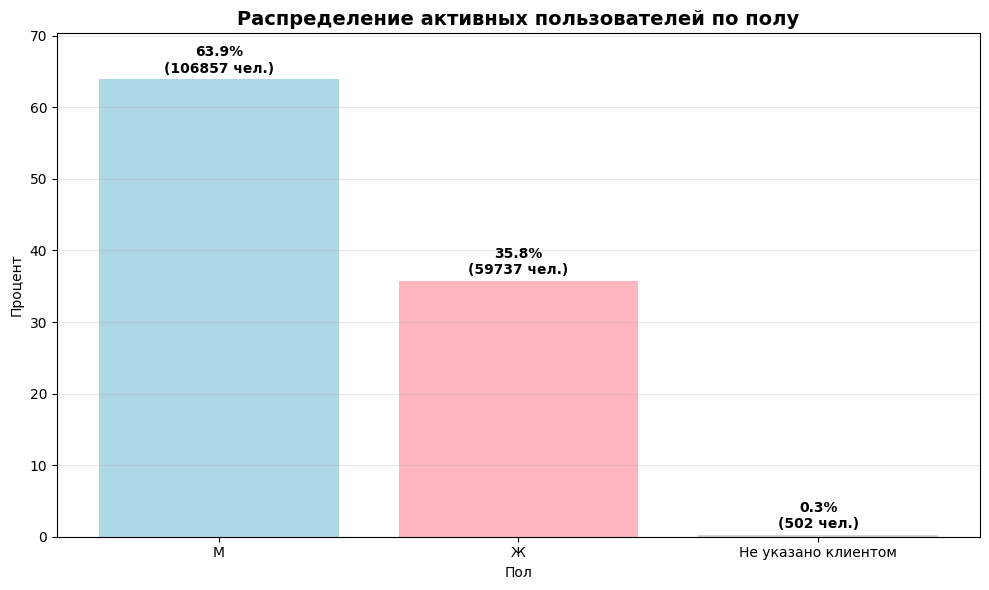

In [70]:
# Анализ распределения по полу
gender_distribution = active_users['sex_type'].value_counts(normalize=True) * 100
gender_counts = active_users['sex_type'].value_counts()

print("РАСПРЕДЕЛЕНИЕ АКТИВНЫХ ПОЛЬЗОВАТЕЛЕЙ ПО ПОЛУ:")
print("=" * 50)
for gender, percentage in gender_distribution.items():
    count = gender_counts[gender]
    print(f"{gender}: {percentage:.1f}% ({count} пользователей)")

# Визуализация с числами
plt.figure(figsize=(10, 6))
bars = plt.bar(gender_distribution.index, gender_distribution.values, 
               color=['lightblue', 'lightpink', 'lightgray'])

# Добавляем числа на столбцы
for bar, percentage, count in zip(bars, gender_distribution.values, gender_counts.values):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.5,
             f'{percentage:.1f}%\n({count} чел.)',
             ha='center', va='bottom', fontweight='bold')

plt.title('Распределение активных пользователей по полу', fontweight='bold', fontsize=14)
plt.ylabel('Процент')
plt.xlabel('Пол')
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.3)
plt.ylim(0, max(gender_distribution.values) * 1.1)
plt.tight_layout()
plt.show()

РАСПРЕДЕЛЕНИЕ АКТИВНЫХ ПОЛЬЗОВАТЕЛЕЙ ПО ВОЗРАСТУ:
35-44 лет: 32.6% (54441 пользователей)
25-34 лет: 25.7% (42876 пользователей)
45-54 лет: 19.5% (32522 пользователей)
18-24 лет: 11.4% (19102 пользователей)
55 лет +: 10.7% (17823 пользователей)
Не указано клиентом: 0.2% (332 пользователей)


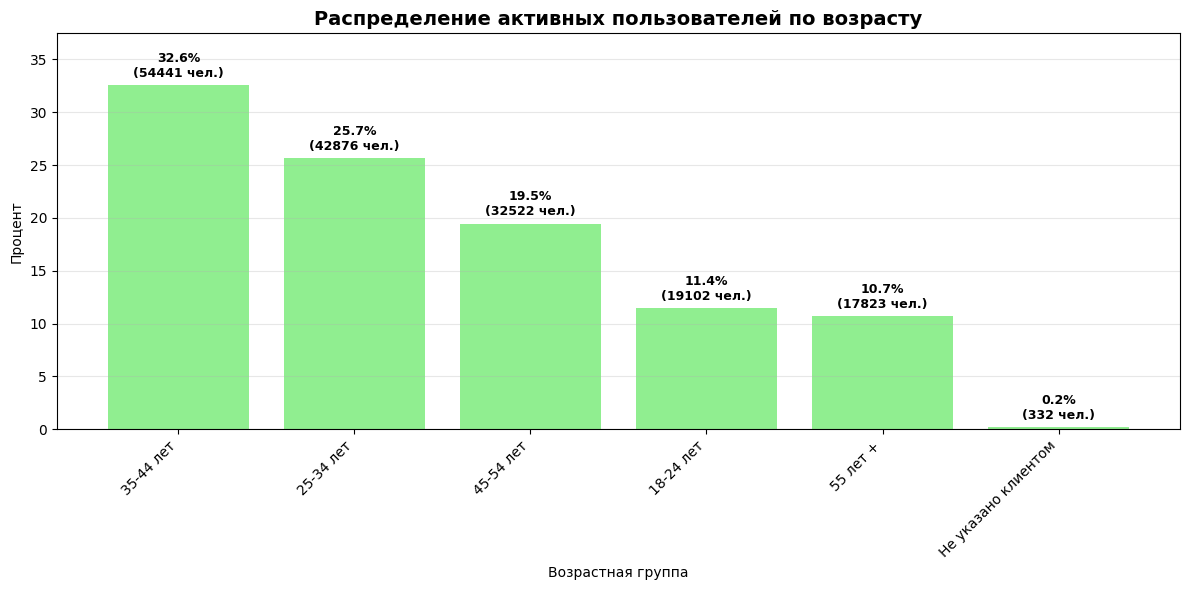

In [71]:
# Анализ распределения по возрасту
age_distribution = active_users['age_segment'].value_counts(normalize=True) * 100
age_counts = active_users['age_segment'].value_counts()

print("РАСПРЕДЕЛЕНИЕ АКТИВНЫХ ПОЛЬЗОВАТЕЛЕЙ ПО ВОЗРАСТУ:")
print("=" * 50)
for age, percentage in age_distribution.items():
    count = age_counts[age]
    print(f"{age}: {percentage:.1f}% ({count} пользователей)")

# Визуализация с числами
plt.figure(figsize=(12, 6))
bars = plt.bar(age_distribution.index, age_distribution.values, color='lightgreen')

# Добавляем числа на столбцы
for bar, percentage, count in zip(bars, age_distribution.values, age_counts.values):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.5,
             f'{percentage:.1f}%\n({count} чел.)',
             ha='center', va='bottom', fontweight='bold', fontsize=9)

plt.title('Распределение активных пользователей по возрасту', fontweight='bold', fontsize=14)
plt.ylabel('Процент')
plt.xlabel('Возрастная группа')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.ylim(0, max(age_distribution.values) * 1.15)
plt.tight_layout()
plt.show()

ТОП КАНАЛОВ ПРИВЛЕЧЕНИЯ АКТИВНЫХ ПОЛЬЗОВАТЕЛЕЙ:
1. Органика: 42.6% (71195 пользователей)
2. Рефералка Sales: 33.5% (56018 пользователей)
3. Маркетинг KZ: 23.9% (39883 пользователей)


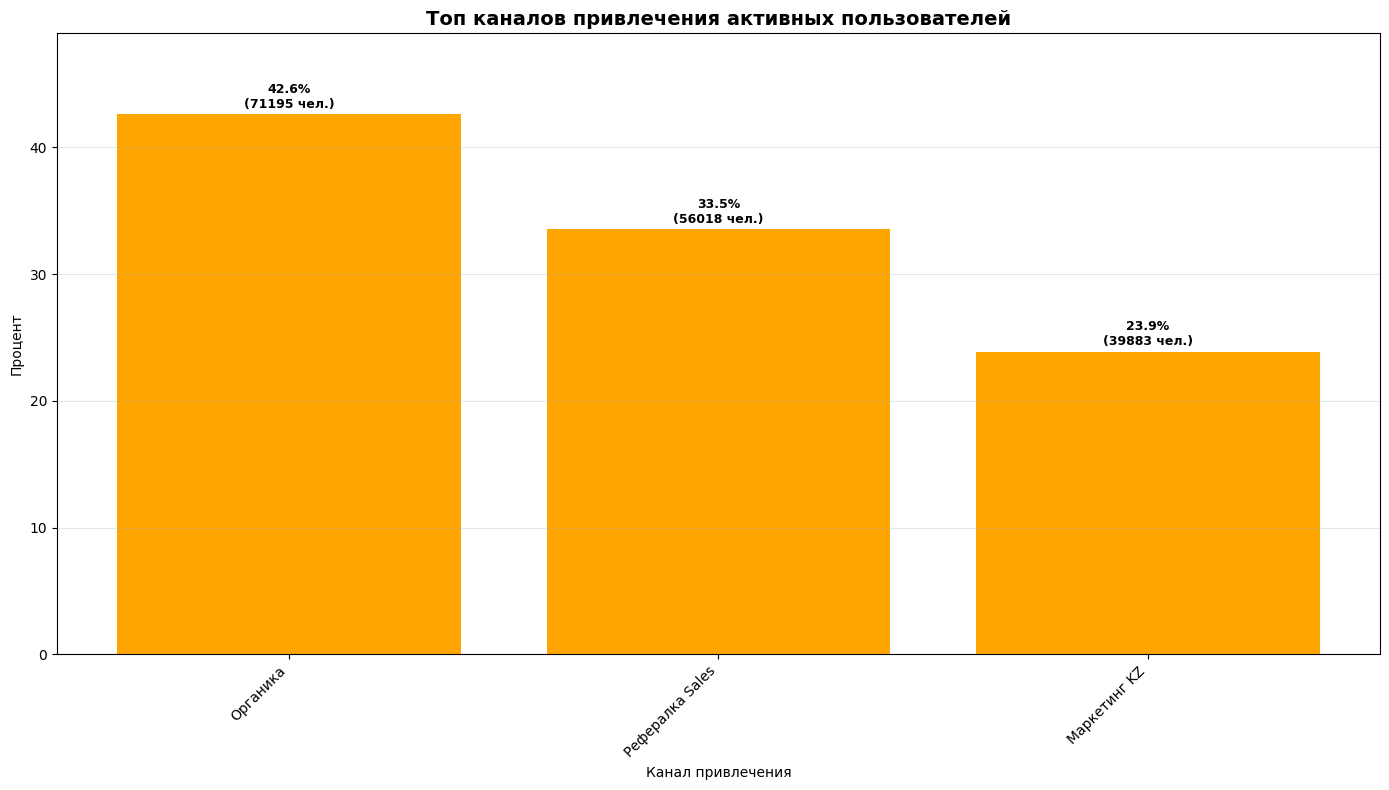

In [76]:
# Анализ каналов привлечения
channel_distribution = active_users['Канал привлечения'].value_counts(normalize=True) * 100
channel_counts = active_users['Канал привлечения'].value_counts()

print("ТОП КАНАЛОВ ПРИВЛЕЧЕНИЯ АКТИВНЫХ ПОЛЬЗОВАТЕЛЕЙ:")
print("=" * 60)
for i, (channel, percentage) in enumerate(channel_distribution.head(10).items(), 1):
    count = channel_counts[channel]
    print(f"{i}. {channel}: {percentage:.1f}% ({count} пользователей)")

# Визуализация топ-10 каналов с числами
plt.figure(figsize=(14, 8))
top_10_channels = channel_distribution.head(10)
top_10_counts = channel_counts.head(10)

bars = plt.bar(top_10_channels.index, top_10_channels.values, color='orange')

# Добавляем числа на столбцы
for bar, percentage, count in zip(bars, top_10_channels.values, top_10_counts.values):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.3,
             f'{percentage:.1f}%\n({count} чел.)',
             ha='center', va='bottom', fontweight='bold', fontsize=9)

plt.title('Топ каналов привлечения активных пользователей', fontweight='bold', fontsize=14)
plt.ylabel('Процент')
plt.xlabel('Канал привлечения')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.ylim(0, max(top_10_channels.values) * 1.15)
plt.tight_layout()
plt.show()

Банк и Белиз не приносят активных клиентов

In [75]:
# Создаем сводный портрет с точными числами
most_common_gender = active_users['sex_type'].mode()[0]
most_common_age = active_users['age_segment'].mode()[0]
most_common_channel = active_users['Канал привлечения'].mode()[0]

gender_percentage = gender_distribution[most_common_gender]
age_percentage = age_distribution[most_common_age]
channel_percentage = channel_distribution[most_common_channel]

gender_count = gender_counts[most_common_gender]
age_count = age_counts[most_common_age]
channel_count = channel_counts[most_common_channel]

print("СВОДНЫЙ ПОРТРЕТ АКТИВНОГО ПОЛЬЗОВАТЕЛЯ:")
print("=" * 60)
print(f"🎯 Типичный активный пользователь:")
print(f"   • Пол: {most_common_gender} ({gender_percentage:.1f}%, {gender_count} пользователей)")
print(f"   • Возраст: {most_common_age} ({age_percentage:.1f}%, {age_count} пользователей)")
print(f"   • Канал привлечения: {most_common_channel} ({channel_percentage:.1f}%, {channel_count} пользователей)")
print(f"   • Всего активных пользователей: {len(active_users)}")
print(f"   • Доля от всех пользователей: {(len(active_users) / len(user_profiles_complete) * 100):.1f}%")

# Дополнительная статистика с числами
print(f"\n📊 Дополнительная статистика:")
print(f"   • Медианное количество событий: {active_users['total_events'].median():.0f}")
print(f"   • Медианное количество активных дней: {active_users['active_days'].median():.0f}")
print(f"   • Медианное количество счетов: {active_users['total_accounts'].median():.0f}")

СВОДНЫЙ ПОРТРЕТ АКТИВНОГО ПОЛЬЗОВАТЕЛЯ:
🎯 Типичный активный пользователь:
   • Пол: М (63.9%, 106857 пользователей)
   • Возраст: 35-44 лет (32.6%, 54441 пользователей)
   • Канал привлечения: Органика (42.6%, 71195 пользователей)
   • Всего активных пользователей: 167111
   • Доля от всех пользователей: 38.9%

📊 Дополнительная статистика:
   • Медианное количество событий: 171
   • Медианное количество активных дней: 75
   • Медианное количество счетов: 2


Теперь сформируем портрет активных пользователей у которых много активов

In [77]:
# Фильтруем активных пользователей с сегментом активов 9-12 (богатые)
wealthy_active_users = active_users[
    (active_users['asset_segment'] != 'Не определен') & 
    (active_users['asset_segment'].astype(int) >= 9)
].copy()

print(f"Активных пользователей с высокими активами (9-12): {len(wealthy_active_users)}")
print(f"Доля от всех активных пользователей: {(len(wealthy_active_users) / len(active_users) * 100):.1f}%")

# Распределение по сегментам активов
asset_distribution = wealthy_active_users['asset_segment'].value_counts().sort_index()
print("\nРаспределение по сегментам активов:")
for segment, count in asset_distribution.items():
    print(f"Сегмент {segment}: {count} пользователей")

Активных пользователей с высокими активами (9-12): 12389
Доля от всех активных пользователей: 7.4%

Распределение по сегментам активов:
Сегмент 9: 5368 пользователей
Сегмент 10: 4006 пользователей
Сегмент 11: 1588 пользователей
Сегмент 12: 1427 пользователей


РАСПРЕДЕЛЕНИЕ БОГАТЫХ АКТИВНЫХ ПОЛЬЗОВАТЕЛЕЙ ПО ПОЛУ:
М: 73.1% (9054 пользователей)
Ж: 24.9% (3088 пользователей)
Не указано клиентом: 2.0% (245 пользователей)


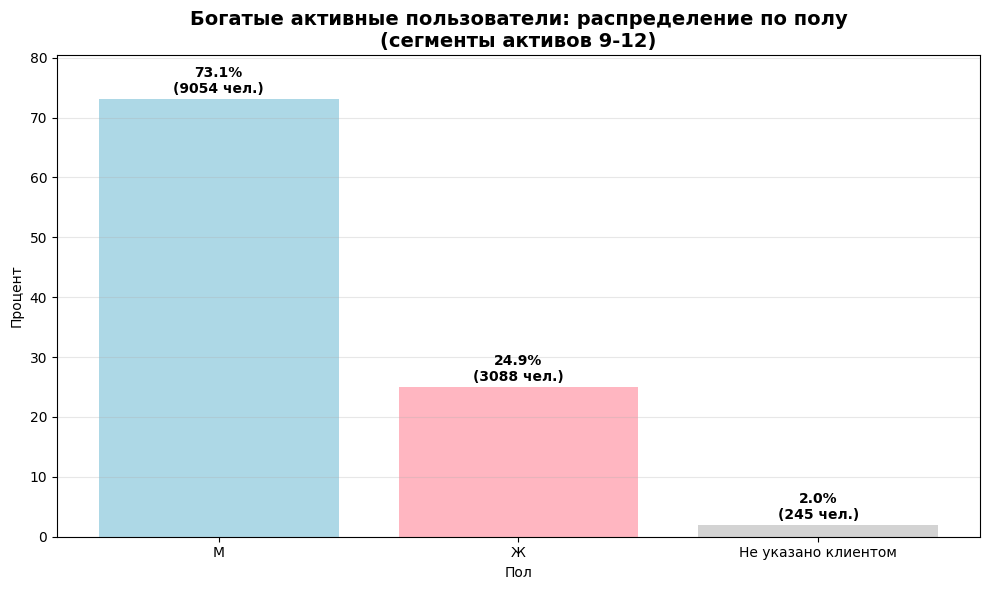

In [79]:
# Анализ распределения по полу
gender_distribution_wealthy = wealthy_active_users['sex_type'].value_counts(normalize=True) * 100
gender_counts_wealthy = wealthy_active_users['sex_type'].value_counts()

print("РАСПРЕДЕЛЕНИЕ БОГАТЫХ АКТИВНЫХ ПОЛЬЗОВАТЕЛЕЙ ПО ПОЛУ:")
print("=" * 60)
for gender, percentage in gender_distribution_wealthy.items():
    count = gender_counts_wealthy[gender]
    print(f"{gender}: {percentage:.1f}% ({count} пользователей)")

# Визуализация с числами
plt.figure(figsize=(10, 6))
bars = plt.bar(gender_distribution_wealthy.index, gender_distribution_wealthy.values, 
               color=['lightblue', 'lightpink', 'lightgray'])

# Добавляем числа на столбцы
for bar, percentage, count in zip(bars, gender_distribution_wealthy.values, gender_counts_wealthy.values):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.5,
             f'{percentage:.1f}%\n({count} чел.)',
             ha='center', va='bottom', fontweight='bold')

plt.title('Богатые активные пользователи: распределение по полу\n(сегменты активов 9-12)', fontweight='bold', fontsize=14)
plt.ylabel('Процент')
plt.xlabel('Пол')
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.3)
plt.ylim(0, max(gender_distribution_wealthy.values) * 1.1)
plt.tight_layout()
plt.show()

РАСПРЕДЕЛЕНИЕ БОГАТЫХ АКТИВНЫХ ПОЛЬЗОВАТЕЛЕЙ ПО ВОЗРАСТУ:
45-54 лет: 33.3% (4126 пользователей)
55 лет +: 30.6% (3791 пользователей)
35-44 лет: 26.8% (3320 пользователей)
25-34 лет: 6.3% (783 пользователей)
Не указано клиентом: 1.9% (239 пользователей)
18-24 лет: 1.0% (128 пользователей)


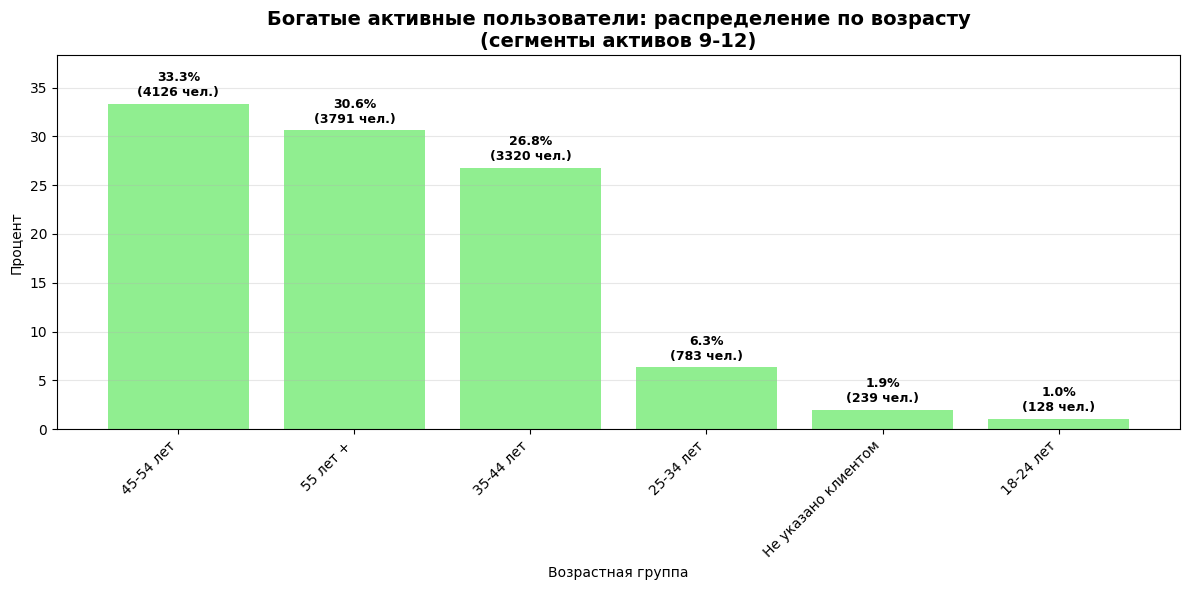

In [80]:
# Анализ распределения по возрасту
age_distribution_wealthy = wealthy_active_users['age_segment'].value_counts(normalize=True) * 100
age_counts_wealthy = wealthy_active_users['age_segment'].value_counts()

print("РАСПРЕДЕЛЕНИЕ БОГАТЫХ АКТИВНЫХ ПОЛЬЗОВАТЕЛЕЙ ПО ВОЗРАСТУ:")
print("=" * 60)
for age, percentage in age_distribution_wealthy.items():
    count = age_counts_wealthy[age]
    print(f"{age}: {percentage:.1f}% ({count} пользователей)")

# Визуализация с числами
plt.figure(figsize=(12, 6))
bars = plt.bar(age_distribution_wealthy.index, age_distribution_wealthy.values, color='lightgreen')

# Добавляем числа на столбцы
for bar, percentage, count in zip(bars, age_distribution_wealthy.values, age_counts_wealthy.values):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.5,
             f'{percentage:.1f}%\n({count} чел.)',
             ha='center', va='bottom', fontweight='bold', fontsize=9)

plt.title('Богатые активные пользователи: распределение по возрасту\n(сегменты активов 9-12)', fontweight='bold', fontsize=14)
plt.ylabel('Процент')
plt.xlabel('Возрастная группа')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.ylim(0, max(age_distribution_wealthy.values) * 1.15)
plt.tight_layout()
plt.show()

ТОП КАНАЛОВ ПРИВЛЕЧЕНИЯ БОГАТЫХ АКТИВНЫХ ПОЛЬЗОВАТЕЛЕЙ:
1. Рефералка Sales: 68.4% (8475 пользователей)
2. Органика: 19.7% (2446 пользователей)
3. Маркетинг KZ: 11.8% (1466 пользователей)


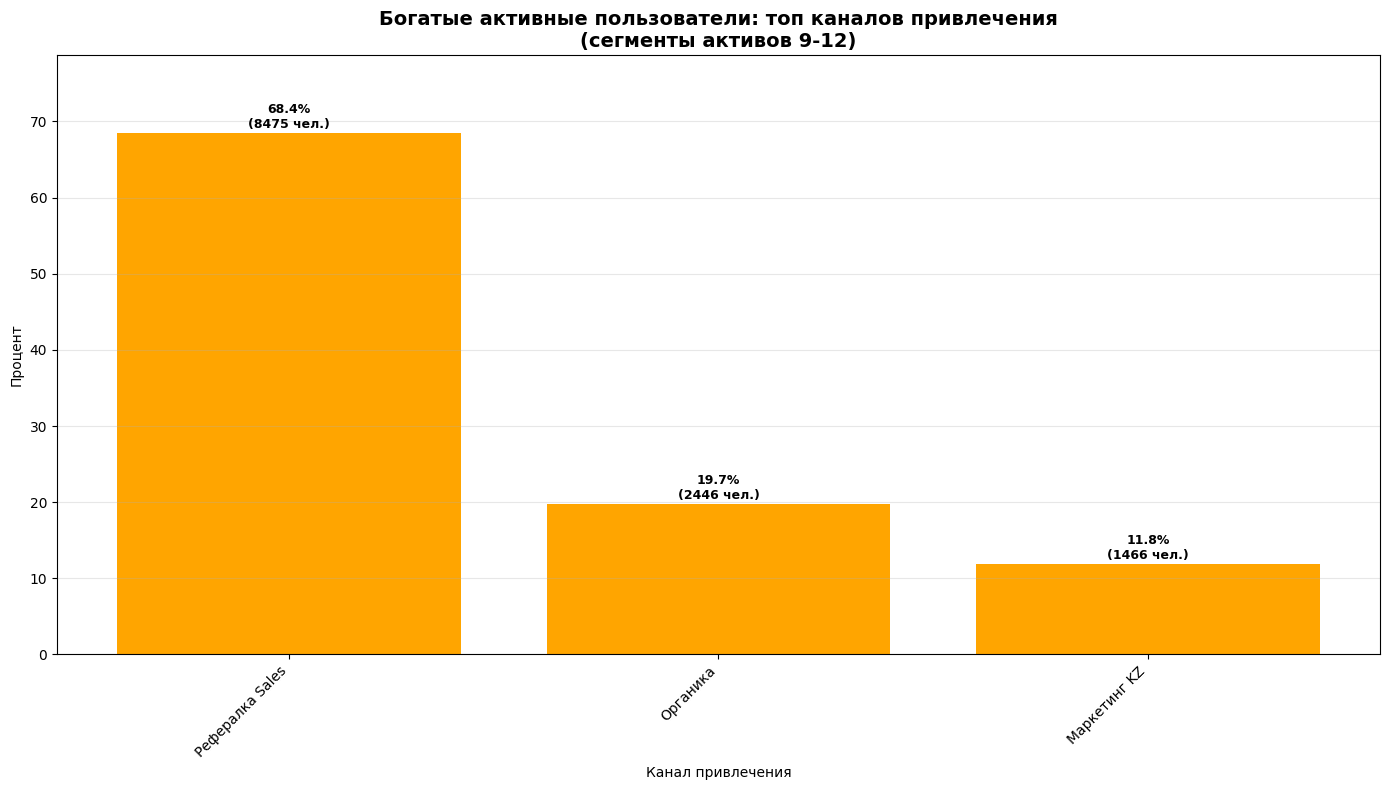

In [82]:
# Анализ топ-10 каналов привлечения
channel_distribution_wealthy = wealthy_active_users['Канал привлечения'].value_counts(normalize=True) * 100
channel_counts_wealthy = wealthy_active_users['Канал привлечения'].value_counts()

print("ТОП КАНАЛОВ ПРИВЛЕЧЕНИЯ БОГАТЫХ АКТИВНЫХ ПОЛЬЗОВАТЕЛЕЙ:")
print("=" * 70)
for i, (channel, percentage) in enumerate(channel_distribution_wealthy.head(10).items(), 1):
    count = channel_counts_wealthy[channel]
    print(f"{i}. {channel}: {percentage:.1f}% ({count} пользователей)")

# Визуализация топ-10 каналов с числами
plt.figure(figsize=(14, 8))
top_10_channels_wealthy = channel_distribution_wealthy.head(10)
top_10_counts_wealthy = channel_counts_wealthy.head(10)

bars = plt.bar(top_10_channels_wealthy.index, top_10_channels_wealthy.values, color='orange')

# Добавляем числа на столбцы
for bar, percentage, count in zip(bars, top_10_channels_wealthy.values, top_10_counts_wealthy.values):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.3,
             f'{percentage:.1f}%\n({count} чел.)',
             ha='center', va='bottom', fontweight='bold', fontsize=9)

plt.title('Богатые активные пользователи: топ каналов привлечения\n(сегменты активов 9-12)', fontweight='bold', fontsize=14)
plt.ylabel('Процент')
plt.xlabel('Канал привлечения')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.ylim(0, max(top_10_channels_wealthy.values) * 1.15)
plt.tight_layout()
plt.show()

In [84]:
# Создаем сводный портрет с точными числами
most_common_gender_wealthy = wealthy_active_users['sex_type'].mode()[0]
most_common_age_wealthy = wealthy_active_users['age_segment'].mode()[0]
most_common_channel_wealthy = wealthy_active_users['Канал привлечения'].mode()[0]

gender_percentage_wealthy = gender_distribution_wealthy[most_common_gender_wealthy]
age_percentage_wealthy = age_distribution_wealthy[most_common_age_wealthy]
channel_percentage_wealthy = channel_distribution_wealthy[most_common_channel_wealthy]

gender_count_wealthy = gender_counts_wealthy[most_common_gender_wealthy]
age_count_wealthy = age_counts_wealthy[most_common_age_wealthy]
channel_count_wealthy = channel_counts_wealthy[most_common_channel_wealthy]

print("СВОДНЫЙ ПОРТРЕТ САМЫХ ЦЕННЫХ ПОЛЬЗОВАТЕЛЕЙ:")
print("=" * 65)
print(f"🎯 Типичный богатый активный пользователь (активы 9-12):")
print(f"   • Пол: {most_common_gender_wealthy} ({gender_percentage_wealthy:.1f}%, {gender_count_wealthy} пользователей)")
print(f"   • Возраст: {most_common_age_wealthy} ({age_percentage_wealthy:.1f}%, {age_count_wealthy} пользователей)")
print(f"   • Канал привлечения: {most_common_channel_wealthy} ({channel_percentage_wealthy:.1f}%, {channel_count_wealthy} пользователей)")
print(f"   • Всего богатых активных пользователей: {len(wealthy_active_users)}")
print(f"   • Доля от всех активных пользователей: {(len(wealthy_active_users) / len(active_users) * 100):.1f}%")

# Сравнение с общими активными пользователями
print(f"\n📊 Сравнение с общими активными пользователями:")
print(f"   • Разница в распределении по полу: {abs(gender_percentage - gender_percentage_wealthy):.1f}%")
print(f"   • Разница в распределении по возрасту: {abs(age_percentage - age_percentage_wealthy):.1f}%")
print(f"   • Разница в основном канале привлечения: {abs(channel_percentage - channel_percentage_wealthy):.1f}%")

# Дополнительная статистика
print(f"\n💼 Дополнительная статистика богатых пользователей:")
print(f"   • Медианное количество событий: {wealthy_active_users['total_events'].median():.0f}")
print(f"   • Медианное количество активных дней: {wealthy_active_users['active_days'].median():.0f}")
print(f"   • Медианное количество счетов: {wealthy_active_users['total_accounts'].median():.0f}")

СВОДНЫЙ ПОРТРЕТ САМЫХ ЦЕННЫХ ПОЛЬЗОВАТЕЛЕЙ:
🎯 Типичный богатый активный пользователь (активы 9-12):
   • Пол: М (73.1%, 9054 пользователей)
   • Возраст: 45-54 лет (33.3%, 4126 пользователей)
   • Канал привлечения: Рефералка Sales (68.4%, 8475 пользователей)
   • Всего богатых активных пользователей: 12389
   • Доля от всех активных пользователей: 7.4%

📊 Сравнение с общими активными пользователями:
   • Разница в распределении по полу: 9.1%
   • Разница в распределении по возрасту: 0.7%
   • Разница в основном канале привлечения: 25.8%

💼 Дополнительная статистика богатых пользователей:
   • Медианное количество событий: 428
   • Медианное количество активных дней: 126
   • Медианное количество счетов: 2


In [17]:
# Сначала посмотрим доступные категории
print("Доступные категории событий:")
print(user_events['name'].value_counts())

# Группировка по категориям
category_activity = user_events.groupby(['user_id', 'name']).agg(
    category_events=('id', 'count')
).reset_index()

# Pivot таблица по категориям
category_pivot = category_activity.pivot_table(
    index='user_id', 
    columns='name', 
    values='category_events', 
    fill_value=0
).reset_index()

Доступные категории событий:
name
Security-related session initiated    5694159
User logged in                        5521778
Authentication completed              5487929
Trade result successful               4592416
Trade order placed                    1903103
                                       ...   
Run ibo_update_company                      2
Fourth referral account registered          1
cps_authenticate                            1
SMS backup configuration modified           1
File reinstated                             1
Name: count, Length: 95, dtype: int64


In [18]:
category_activity.head()

,user_id,name,category_events
0,151692,Dormant Account Status Updated,1
1,151692,Logged as admin,13
2,151692,Security-related session initiated,98
3,151692,Trade IPO stock,1
4,151692,Trade order placed,6


In [26]:
# Определяем ключевые события онбординга из описания
onboarding_events = [
    'Account successfully created for user',
    'Account setup completed successfully',
    'Initiated account registration', 
    'Account set up through a mobile device',
    'User session established',
    'User profile status changed',
    'Chosen a pricing plan for the accoun',
    'Unable to create account',
    'Account opened successfully',
    'Switched to live environment',
    'Account registered under a personal name',
    'Account created for a business or organization'
]

# Проверяем, какие события действительно есть в данных
available_events = user_events['name'].unique()
existing_onboarding_events = [event for event in onboarding_events if event in available_events]

print(f"Из {len(onboarding_events)} событий онбординга найдено {len(existing_onboarding_events)}")

# Создаем матрицу прохождения онбординга
onboarding_users = user_events[user_events['name'].isin(existing_onboarding_events)]\
    .groupby('user_id')['name'].unique().reset_index()

# Создаем бинарные признаки для каждого этапа
for event in existing_onboarding_events:
    onboarding_users[f'completed_{event}'] = onboarding_users['name'].apply(
        lambda x: 1 if event in x else 0
    )

onboarding_users.drop('name', axis=1, inplace=True)

Из 12 событий онбординга найдено 12


In [28]:
onboarding_users.head()

,user_id,completed_Account successfully created for user,completed_Account setup completed successfully,completed_Initiated account registration,completed_Account set up through a mobile device,completed_User session established,completed_User profile status changed,completed_Chosen a pricing plan for the accoun,completed_Unable to create account,completed_Account opened successfully,completed_Switched to live environment,completed_Account registered under a personal name,completed_Account created for a business or organization
0,1226937,0,0,0,0,1,1,0,1,1,1,0,0
1,1269983,0,0,0,0,1,0,0,0,0,0,0,0
2,1272951,0,0,0,0,1,0,0,0,0,0,0,0
3,1312216,0,0,0,1,0,1,0,0,1,1,0,0
4,1314597,0,0,0,0,0,1,0,0,0,0,0,0


In [29]:
onboarding_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96620 entries, 0 to 96619
Data columns (total 13 columns):
 #   Column                                                    Non-Null Count  Dtype
---  ------                                                    --------------  -----
 0   user_id                                                   96620 non-null  int64
 1   completed_Account successfully created for user           96620 non-null  int64
 2   completed_Account setup completed successfully            96620 non-null  int64
 3   completed_Initiated account registration                  96620 non-null  int64
 4   completed_Account set up through a mobile device          96620 non-null  int64
 5   completed_User session established                        96620 non-null  int64
 6   completed_User profile status changed                     96620 non-null  int64
 7   completed_Chosen a pricing plan for the accoun            96620 non-null  int64
 8   completed_Unable to create account  

In [30]:
# Создаем сегменты активности
def create_activity_segments(row):
    total_events = row['total_events']
    
    if total_events >= 100:
        return 'Супер-активные'
    elif total_events >= 50:
        return 'Очень активные'
    elif total_events >= 20:
        return 'Активные'
    elif total_events >= 5:
        return 'Умеренные'
    elif total_events > 0:
        return 'Пассивные'
    else:
        return 'Неактивные'

user_activity['activity_segment'] = user_activity.apply(create_activity_segments, axis=1)

In [31]:
user_activity['activity_segment'].value_counts()

activity_segment
Пассивные         174512
Умеренные          92661
Супер-активные     72660
Активные           52972
Очень активные     26410
Name: count, dtype: int64

In [ ]:
# Объединяем все данные
user_portraits = user_activity.merge(
    onboarding_users, 
    on='user_id', 
    how='left'
).merge(
    category_pivot,
    on='user_id',
    how='left'
)

# Заполняем пропуски
user_portraits = user_portraits.fillna(0)

# Добавляем демографические данные из body_users (если есть)
try:
    user_portraits = user_portraits.merge(
        body_users[['user_id', 'Канал привлечения', 'Sex_type', 'Age_segment']],
        on='user_id',
        how='left'
    )
except:
    print("Нет данных body_users или разные названия столбцов")

# Добавляем сегменты из user_segment
try:
    user_portraits = user_portraits.merge(
        user_segment[['user_id', 'User_segment_in_reception_id']],
        on='user_id',
        how='left'
    )
except:
    print("Нет данных user_segment или разные названия столбцов")

# Просмотрим результат
print("Размерность портретов пользователей:", user_portraits.shape)
print("\nПервые 5 строк:")
print(user_portraits.head())